In [1]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
from src.algorithms.vae import VaeAlgo
from src.utils.util import *
from src.dataset.wadi import WadiDataset
from src.model.modelvae import *

In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


01:18:34


<h4>Initializing Dataset</h4>

In [4]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class Datasettings:
    
    def __init__(self):
        self.dataset_training_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_14days.csv"
        self.dataset_test_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_attackdata.csv"
        self.dataset_anomaly_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_anomalies.csv"
        self.train=True
        self.window_length=60

In [5]:
seed=0
data_settings = Datasettings()
wadi = WadiDataset(seed,data_settings)

In [6]:
x_train, y_train, x_test, y_test = wadi.data()

(1209601, 126)
Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 9948
% of anomalies in the test set = 5.7569111289865225
number of anomalous events = 14


In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [8]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [9]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [10]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [11]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = wadi.window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [13]:
embedding_dim=16
vaeAlgo=VaeAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [14]:
trained_model=vaeAlgo.train_vaeautoencoder(train_loader)

/libraries/Default_env_55311/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

In [15]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/vae/wadi/wadi.pkl'

In [ ]:
torch.save(trained_model.module.state_dict(), PATH)

In [16]:
state_dict = torch.load(PATH)
trained_model=VAE(embedding_dim, n_features,device=device)
trained_model=nn.DataParallel(trained_model)
trained_model.to(device)
trained_model=vaeAlgo.load_model(state_dict,trained_model)

<h4>Loading back the saved models</h4>

In [17]:
vaeAlgo.intialize_lstmvaeautoencoder(trained_model)

<h2>Testing for anomaly</h2>


In [18]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [20]:
losses=vaeAlgo.predict_loss(test_loader)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

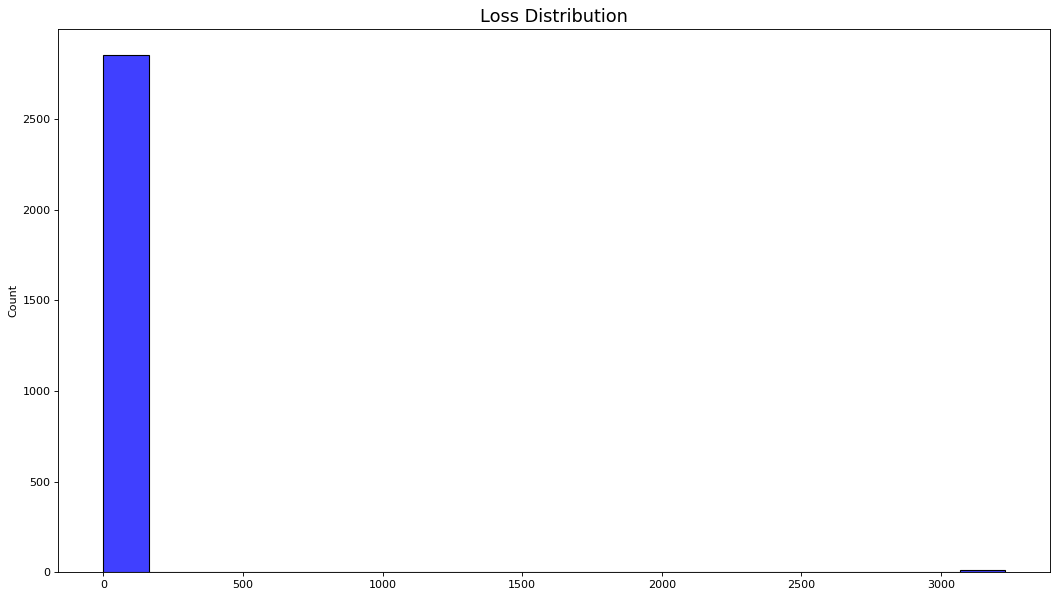

In [22]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

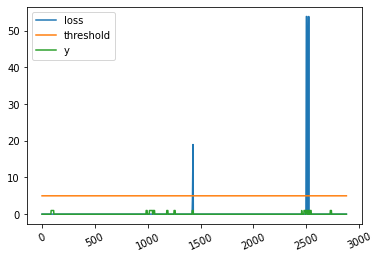

In [38]:
THRESHOLD =5

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [39]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [40]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 29
True Negative	 2699
False Positive	 3
False Negative	 149
Accuracy	 0.9472222222222222
Precision	 0.90625
Recall	 0.16292134831460675
f-measure	 0.2761904761904762
cohen_kappa_score	 0.2622950819672131
auc	 0.5809055298197757
roc_auc	 0.5809055298197757
